In [1]:
import numpy as np
import scipy.linalg as linalg
import pandas as pd
import time
import scipy.optimize as op
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from cobaya import run

c = 299792.458#km/s

# Carregando os dados
## CC

In [2]:
zhzi, hzi, shzi, metodo = np.genfromtxt("data/Hz32Clocks.txt", comments='#', usecols=(0,1,2,3), unpack=True, dtype=('f8', 'f8', 'f8', 'U1'))
zmod, imf, slib, sps, spsooo = np.genfromtxt("data/data_MM20.dat", comments='#', usecols=(0,1,2,3,4), unpack=True)

#Separando os métodos
zhzi_FSF, hzi_FSF, shzi_FSF = [],[],[]
zhzi_D4000, hzi_D4000, shzi_D4000 = [],[],[]

for i in range(len(metodo)):
    if metodo[i]=="F":
        zhzi_FSF.append(zhzi[i])
        hzi_FSF.append(hzi[i])
        shzi_FSF.append(shzi[i])
    elif metodo[i]=="D":
        zhzi_D4000.append(zhzi[i])
        hzi_D4000.append(hzi[i])
        shzi_D4000.append(shzi[i])

zhzi_FSF = np.array(zhzi_FSF)
hzi_FSF = np.array(hzi_FSF)
shzi_FSF = np.array(shzi_FSF)

zhzi_D4000 = np.array(zhzi_D4000)
hzi_D4000 = np.array(hzi_D4000)
shzi_D4000 = np.array(shzi_D4000)

### Matriz de covariância

In [3]:
ndata_FSF = len(zhzi_FSF)
cov_stat_FSF = np.zeros((ndata_FSF, ndata_FSF), dtype='float64')

for i in range(ndata_FSF):
    cov_stat_FSF[i,i] = shzi_FSF[i]**2

imf_intp_FSF = np.interp(zhzi_FSF, zmod, imf)/100
spsooo_intp_FSF = np.interp(zhzi_FSF, zmod, spsooo)/100

cov_imf_FSF = np.zeros((ndata_FSF, ndata_FSF), dtype='float64')
cov_spsooo_FSF = np.zeros((ndata_FSF, ndata_FSF), dtype='float64')

for i in range(ndata_FSF):
    for j in range(ndata_FSF):
        cov_imf_FSF[i,j] = hzi_FSF[i] * imf_intp_FSF[i] * hzi_FSF[j] * imf_intp_FSF[j]
        cov_spsooo_FSF[i,j] = hzi_FSF[i] * spsooo_intp_FSF[i] * hzi_FSF[j] * spsooo_intp_FSF[j]

cov_mat_FSF = cov_imf_FSF + cov_spsooo_FSF + cov_stat_FSF
inv_cov_FSF = linalg.inv(cov_mat_FSF)

In [4]:
ndata_D4000 = len(zhzi_D4000)
cov_stat_D4000 = np.zeros((ndata_D4000, ndata_D4000), dtype='float64')

for i in range(ndata_D4000):
    cov_stat_D4000[i,i] = shzi_D4000[i]**2

imf_intp_D4000 = np.interp(zhzi_D4000, zmod, imf)/100
spsooo_intp_D4000 = np.interp(zhzi_D4000, zmod, spsooo)/100

cov_imf_D4000 = np.zeros((ndata_D4000, ndata_D4000), dtype='float64')
cov_spsooo_D4000 = np.zeros((ndata_D4000, ndata_D4000), dtype='float64')

for i in range(ndata_D4000):
    for j in range(ndata_D4000):
        cov_imf_D4000[i,j] = hzi_D4000[i] * imf_intp_D4000[i] * hzi_D4000[j] * imf_intp_D4000[j]
        cov_spsooo_D4000[i,j] = hzi_D4000[i] * spsooo_intp_D4000[i] * hzi_D4000[j] * spsooo_intp_D4000[j]

cov_mat_D4000 = cov_imf_D4000 + cov_spsooo_D4000 + cov_stat_D4000
inv_cov_D4000 = linalg.inv(cov_mat_D4000)

In [3]:
def CovMatTot(f):
    ndata= len(zhzi)
    cov_stat = np.zeros((ndata, ndata), dtype='float64')
    
    for i in range(ndata):
        cov_stat[i,i] = shzi[i]**2
    
    imf_intp = np.interp(zhzi, zmod, imf)/100
    spsooo_intp = np.interp(zhzi, zmod, spsooo)/100
    
    cov_imf = np.zeros((ndata, ndata), dtype='float64')
    cov_spsooo = np.zeros((ndata, ndata), dtype='float64')
    
    for i in range(ndata):
        for j in range(ndata):
            cov_imf[i,j] = hzi[i] * imf_intp[i] * hzi[j] * imf_intp[j]
            cov_spsooo[i,j] = hzi[i] * spsooo_intp[i] * hzi[j] * spsooo_intp[j]
    
    cov_mat= cov_imf + cov_spsooo + (f**2)*cov_stat
    inv_cov = linalg.inv(cov_mat)

    return cov_mat, inv_cov

In [4]:
def build_data(datafile,SH0ES):    
    global origlen, wwPS, wwPPlus, cepheid_distance, is_calibrator, zHELPS, zHELPPlus

    print("Loading data from {}".format(datafile))
    data = pd.read_csv(datafile, sep=r'\s+')
    origlen = len(data)
    
    if SH0ES:
        ww = (data['zHD']>0.01) | (np.array(data['IS_CALIBRATOR'],dtype=bool))
        wwPS = ww
        zHELPS = data['zHEL'][ww]
    else:
        ww = (data['zHD']>0.01)
        wwPPlus = ww
        zHELPPlus = data['zHEL'][ww]

    zCMB = data['zHD'][ww] #use the vpec corrected redshift for zCMB 
    
    m_obs = data['m_b_corr'][ww]
    if SH0ES:
        is_calibrator = data['IS_CALIBRATOR'][ww]
        cepheid_distance = data['CEPH_DIST'][ww]

    return zCMB, m_obs

def build_covariance(covdatafile, SH0ES):
    print("Loading covariance from {}".format(covdatafile))

    f = open(covdatafile)
    line = f.readline()
    if SH0ES:
        n = int(len(zCMBPS))
        ww = wwPS
    else:
        n = int(len(zCMBPPlus))
        ww = wwPPlus
    C = np.zeros((n,n))
    ii = -1
    jj = -1
    mine = 999
    maxe = -999
    for i in range(origlen):
        jj = -1
        if ww[i]:
            ii += 1
        for j in range(origlen):
            if ww[j]:
                jj += 1
            val = float(f.readline())
            if ww[i]:
                if ww[j]:
                    C[ii,jj] = val
    f.close()
    
    print('Done')
    
    return C

zCMBPPlus, m_obsPPlus = build_data('data/Pantheon+SH0ES.dat',SH0ES=False)

covPPlus = build_covariance('data/Pantheon+SH0ES_STAT+SYS.cov', SH0ES=False)
invcovPPlus = linalg.inv(covPPlus)

Loading data from data/Pantheon+SH0ES.dat
Loading covariance from data/Pantheon+SH0ES_STAT+SYS.cov
Done


# Modelos

In [5]:
def extract_theory_points(theory_x, theory_y, pars, SH0ES):
    M = pars[0]
    
    f = interp1d(theory_x, theory_y)#, kind=self.kind)
    
    if SH0ES:
        theory_ynew = zCMBPS*np.nan
        theory_ynew[np.array(is_calibrator,dtype='bool')] = cepheid_distance[np.array(is_calibrator,dtype='bool')]
        
        zcmb = zCMBPS[~np.array(is_calibrator,dtype='bool')]
        zhel = zHELPS[~np.array(is_calibrator,dtype='bool')]
    else:
        theory_ynew = zCMBPPlus*np.nan
        zcmb = zCMBPPlus
        zhel = zHELPPlus
    
    fz = f(zcmb)
    if np.any(fz<=0):
        NegDist = True
        return 1
    if SH0ES:
        theory_ynew[~np.array(is_calibrator,dtype='bool')] = 5.0*np.log10((1.0+zcmb)*(1.0+zhel)*\
                                                                          np.atleast_1d(fz))+25.
    else:
        theory_ynew = 5.0*np.log10((1.0+zcmb)*(1.0+zhel)*np.atleast_1d(fz))+25.
            
    return theory_ynew + M

def extract_theory_pointsHz_FSF(theory_x, theory_y, pars):
    theory_ynew = zhzi_FSF*np.nan  

    f = interp1d(theory_x, theory_y)
    theory_ynew = np.atleast_1d(f(zhzi_FSF))
    return theory_ynew

def extract_theory_pointsHz_D4000(theory_x, theory_y, pars):
    theory_ynew = zhzi_D4000*np.nan  

    f = interp1d(theory_x, theory_y)
    theory_ynew = np.atleast_1d(f(zhzi_D4000))
    return theory_ynew

def extract_theory_pointsHz(theory_x, theory_y, pars):
    theory_ynew = zhzi*np.nan  

    f = interp1d(theory_x, theory_y)
    theory_ynew = np.atleast_1d(f(zhzi))
    return theory_ynew
    
N = 3000
zt = np.linspace(0,2.5,N)

In [6]:
def Ez(z, dc, theta):
    M, H0, Om = theta
    return np.sqrt(Om*(1+z)**3+1-Om)
    
#Distancia comovel adimensional
def DcModel(z, theta):
    ez = lambda z2, x, theta: 1/Ez(z2, 1, theta)
    sol = solve_ivp(ez, [z[0],z[-1]], [0.0], t_eval=z, args=(theta,), method='RK45')

    return sol.y[0]

#Distancia comovel transversal in pc
def dmModel(z, theta):
    M, H0, Om = theta

    dH = c/H0
    wk = 0
    Dcm = DcModel(z, theta)
    if wk < 0:
        return dH*np.sin(np.sqrt(-wk)*Dcm)/np.sqrt(-wk)
    elif wk > 0:
        return dH*np.sinh(np.sqrt(wk)*Dcm)/np.sqrt(wk)
    return dH*Dcm

#distancia de luminosidade in pc
def dlModel(z,theta):
    return (1+z)*dmModel(z,theta)

def daModel(z,theta):
    return dmModel(z,theta)/(1+z)

def muModel(z,theta):
    return 5.*np.log10(dlModel(z,theta))+25

# Funções estatísticas

In [7]:
def find_bestfit(lnlike, parnames, par_ml):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda *args: -2 * lnlike(*args)
    result = op.minimize(chi2, par_ml)
    if not result['success']:
        result = op.minimize(chi2, par_ml, method='Nelder-Mead',options={'maxiter': 10000})#, args=data
    par_ml = result["x"]
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print("tempo total: {0:5.3f} seg".format(t2-t1))
    return result

def run_cobaya(info, info_post):
    print("----- INICIANDO SAMPLER -----")
    t1 = time.time()

    # Roda o sampler
    updated_info, sampler = run(info)

    # Retira o início 
    print("----- RETIRANDO O INICIO -----")
    updated_info_post, sampler_post = run(info_post)

    print(f"Tempo de execução: {time.time()-t1} s")

    return sampler, sampler_post

def getparPPHz_FSF(theta):
    M, H0, Om = theta
    return lnprobPPHz_FSF(M, H0, Om)

def getparPPHz_D4000(theta):
    M, H0, Om = theta
    return lnprobPPHz_D4000(M, H0, Om)

def getparPPHz(theta):
    M, H0, Om, f = theta
    return lnprobPPHz(M, H0, Om, f)

def chi2PP(theta):#Pantheon+
    zhzi = zCMBPPlus
    Ez2i = Ez(zhzi,1,theta)
    if np.any(Ez2i <= 0):
        return np.inf

    dAt = daModel(zt,theta)
    NegDist = False
    mmod = extract_theory_points(zt, dAt, theta,SH0ES=False)
    if NegDist:
        return np.inf
    dmu = mmod-m_obsPPlus
    SA  = np.sum(invcovPPlus)
    Sr  = np.sum(np.dot(dmu.T,invcovPPlus))
    Srr = np.dot(np.dot(dmu.T,invcovPPlus),dmu)
    return Srr - Sr**2./SA
        
def chi2Hz_FSF(theta):#CC Hz
    M, H0, Om = theta
        
    Ezt = Ez(zhzi_FSF,1,theta)
    if np.any(Ezt<0):
        return np.inf
    Hzt = H0*Ezt
    Hzm = extract_theory_pointsHz_FSF(zhzi_FSF, Hzt, theta)
   
    dh = Hzm-hzi_FSF
    
    return np.dot(np.dot(dh.T,inv_cov_FSF),dh)

def chi2Hz_D4000(theta):#CC Hz
    M, H0, Om = theta
        
    Ezt = Ez(zhzi_D4000,1,theta)
    if np.any(Ezt<0):
        return np.inf
    Hzt = H0*Ezt
    Hzm = extract_theory_pointsHz_D4000(zhzi_D4000, Hzt, theta)
   
    dh = Hzm-hzi_D4000
    
    return np.dot(np.dot(dh.T,inv_cov_D4000),dh)

def chi2Hz(theta):#CC Hz
    M, H0, Om, f, inv_cov = theta
        
    Ezt = Ez(zhzi,1,[M, H0, Om])
    if np.any(Ezt<0):
        return np.inf
    Hzt = H0*Ezt
    Hzm = extract_theory_pointsHz(zhzi, Hzt, theta)
   
    dh = Hzm-hzi
    
    return np.dot(np.dot(dh.T,inv_cov),dh)

def lnlikePP(theta):
    return -0.5*chi2PP(theta)

def lnlikeHz_FSF(theta):
    return -0.5*chi2Hz_FSF(theta)

def lnlikeHz_D4000(theta):
    return -0.5*chi2Hz_D4000(theta)

def lnlikeHz(theta):
    M, H0, Om, f = theta
    cov_mat, inv_cov = CovMatTot(f)
    return -0.5*np.log(linalg.det(cov_mat))-0.5*chi2Hz([M, H0, Om, f, inv_cov])
    
def lnprobPPHz_FSF(M, H0, Om):
    theta = [M, H0, Om]
    #if not (0.0 <= Om <= 1.0) or not (H0 > 0):
    #    return -np.inf
    return lnlikePP(theta)+lnlikeHz_FSF(theta)

def lnprobPPHz_D4000(M, H0, Om):
    theta = [M, H0, Om]
    #if not (0.0 <= Om <= 1.0) or not (H0 > 0):
    #    return -np.inf
    return lnlikePP(theta)+lnlikeHz_D4000(theta)

def lnprobPPHz(M, H0, Om, f):
    theta = [M, H0, Om, f]
    return lnlikeHz(theta)

# Análise do modelo

In [8]:
parlabels_LCDM = ["M", "H_0","O_m"]
parlabtex_LCDM = ["M", "$H_0$",r'$\Omega_0$']
parnames_LCDM = ["M", "H0","Om"]
par0_LCDM=[-19.2, 73.03398760350208, 0.2480895086492853]
ndim_LCDM = len(par0_LCDM)

## FSF

In [53]:
par_ml_FSF = par0_LCDM
result_FSF = find_bestfit(getparPPHz_FSF, parnames_LCDM, par_ml_FSF)
par_ml_FSF =result_FSF['x']
print('\n',par_ml_FSF,'\n')
print(result_FSF,'\n')

Maximum likelihood result:
M  =  -19.960566059752253
H0  =  68.13995087075624
Om  =  0.32916158604696033
chi2min = 1411.297547341464
tempo total: 2.850 seg

 [-19.96056606  68.13995087   0.32916159] 

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1411.297547341464
             x: [-1.996e+01  6.814e+01  3.292e-01]
           nit: 80
          nfev: 150
 final_simplex: (array([[-1.996e+01,  6.814e+01,  3.292e-01],
                       [-1.996e+01,  6.814e+01,  3.292e-01],
                       [-1.996e+01,  6.814e+01,  3.292e-01],
                       [-1.996e+01,  6.814e+01,  3.292e-01]]), array([ 1.411e+03,  1.411e+03,  1.411e+03,  1.411e+03])) 



In [56]:
info_FSF = {
    "likelihood": {
        "lnlikehz": lnprobPPHz_FSF
    },

    "params": {
        "M": {"prior": {"min": -19.5, "max": 19.5}, "proposal": par_ml_FSF[0], "latex": "M"},
        "H0": {"prior": {"min": 40.0, "max": 100.0}, "proposal": par_ml_FSF[1], "latex": r"H_{0}"},
        "Om": {"prior": {"min": 0, "max": 0.5}, "proposal": par_ml_FSF[2], "latex": r"O_{m}"}
    },

    "sampler": {
        "polychord": {
            "nlive": 200
        }
    },

    "output": "chains/FSF"
}

info_post_FSF = {
    "output": "chains/FSF",
    "post": {
        "skip_samples": 0.3,
        "suffix": "_post"
    }
}

In [59]:
_, sampler_FSF = run_cobaya(info_FSF, info_post_FSF)

----- INICIANDO SAMPLER -----
[output] Output to be read-from/written-into folder 'chains', with prefix 'FSF'
[lnlikehz] Initialized external likelihood.
[polychord] `pypolychord` module loaded successfully from /home/nirk20/jupyter_venv/lib/python3.12/site-packages/pypolychord
[polychord] Storing raw PolyChord output in 'chains/FSF_polychord_raw'.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {lnlikehz: 173.0}
[polychord] Parameter blocks and their oversampling factors:
[polychord] * 1 : ['M', 'H0', 'Om']
[polychord] Calling PolyChord...
PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     200
nDims    :       3
nDerived :       2
Doing Clustering
Synchronous parallelisation
Generating equally weighted post

## D4000

In [10]:
par_ml_D4000 = par0_LCDM
result_D4000 = find_bestfit(getparPPHz_D4000, parnames_LCDM, par_ml_D4000)
par_ml_D4000 =result_D4000['x']
print('\n',par_ml_D4000,'\n')
print(result_D4000,'\n')

Maximum likelihood result:
M  =  -19.30772522936979
H0  =  67.27603281555524
Om  =  0.33113387135300476
chi2min = 1409.0455193064151
tempo total: 2.891 seg

 [-19.30772523  67.27603282   0.33113387] 

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1409.0455193064151
             x: [-1.931e+01  6.728e+01  3.311e-01]
           nit: 81
          nfev: 157
 final_simplex: (array([[-1.931e+01,  6.728e+01,  3.311e-01],
                       [-1.931e+01,  6.728e+01,  3.311e-01],
                       [-1.931e+01,  6.728e+01,  3.311e-01],
                       [-1.931e+01,  6.728e+01,  3.311e-01]]), array([ 1.409e+03,  1.409e+03,  1.409e+03,  1.409e+03])) 



In [11]:
info_D4000 = {
    "likelihood": {
        "lnlikehz": lnprobPPHz_D4000
    },

    "params": {
        "M": {"prior": {"min": -19.5, "max": 19.5}, "proposal": par_ml_D4000[0], "latex": "M"},
        "H0": {"prior": {"min": 40.0, "max": 100.0}, "proposal": par_ml_D4000[1], "latex": r"H_{0}"},
        "Om": {"prior": {"min": 0, "max": 0.5}, "proposal": par_ml_D4000[2], "latex": r"O_{m}"}
    },

    "sampler": {
        "polychord": {
            "nlive": 200
        }
    },

    "output": "chains/D4000"
}

info_post_D4000 = {
    "output": "chains/D4000",
    "post": {
        "skip_samples": 0.3,
        "suffix": "_post"
    }
}

In [12]:
_, sampler_D4000 = run_cobaya(info_D4000, info_post_D4000)

----- INICIANDO SAMPLER -----
[output] Output to be read-from/written-into folder 'chains', with prefix 'D4000'
[lnlikehz] Initialized external likelihood.
[polychord] `pypolychord` module loaded successfully from /home/nirk20/jupyter_venv/lib/python3.12/site-packages/pypolychord
[polychord] Storing raw PolyChord output in 'chains/D4000_polychord_raw'.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {lnlikehz: 119.0}
[polychord] Parameter blocks and their oversampling factors:
[polychord] * 1 : ['M', 'H0', 'Om']
[polychord] Calling PolyChord...
PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     200
nDims    :       3
nDerived :       2
Doing Clustering
Synchronous parallelisation
Generating equally weighted 

## Dados totais

In [8]:
parlabels_LCDM = ["M", "H_0","O_m", "f"]
parlabtex_LCDM = ["M", "$H_0$",r'$\Omega_0$', "$f$"]
parnames_LCDM = ["M", "H0","Om", "f"]
par0_LCDM=[-19.2, 73.03398760350208, 0.2480895086492853, 0.9]
ndim_LCDM = len(par0_LCDM)

In [9]:
par_ml = par0_LCDM
result = find_bestfit(getparPPHz, parnames_LCDM, par_ml)
par_ml =result['x']
print('\n',par_ml,'\n')
print(result,'\n')

Maximum likelihood result:
M  =  -19.891333030243864
H0  =  67.10578866852168
Om  =  0.3259954100668737
f  =  0.6829128378896276
chi2min = 192.81645010431933
tempo total: 0.624 seg

 [-19.89133303  67.10578867   0.32599541   0.68291284] 

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 192.81645010431933
             x: [-1.989e+01  6.711e+01  3.260e-01  6.829e-01]
           nit: 113
          nfev: 197
 final_simplex: (array([[-1.989e+01,  6.711e+01,  3.260e-01,  6.829e-01],
                       [-1.989e+01,  6.711e+01,  3.260e-01,  6.829e-01],
                       ...,
                       [-1.989e+01,  6.711e+01,  3.260e-01,  6.829e-01],
                       [-1.989e+01,  6.711e+01,  3.260e-01,  6.829e-01]],
                      shape=(5, 4)), array([ 1.928e+02,  1.928e+02,  1.928e+02,  1.928e+02,
                        1.928e+02])) 



In [10]:
info = {
    "likelihood": {
        "lnlikehz": lnprobPPHz
    },

    "params": {
        "M": {"prior": {"min": -19.5, "max": 19.5}, "proposal": par_ml[0], "latex": "M"},
        "H0": {"prior": {"min": 40.0, "max": 100.0}, "proposal": par_ml[1], "latex": r"H_{0}"},
        "Om": {"prior": {"min": 0, "max": 0.5}, "proposal": par_ml[2], "latex": r"O_{m}"},
        "f": {"prior": {"min": 0, "max": 5}, "proposal": par_ml[3], "latex": r"f"}
    },

    "sampler": {
        "polychord": {
            "nlive": 200
        }
    },

    "output": "chains/Total"
}

info_post = {
    "output": "chains/Total",
    "post": {
        "skip_samples": 0.3,
        "suffix": "_post"
    }
}

In [11]:
_, sampler = run_cobaya(info, info_post)

----- INICIANDO SAMPLER -----
[output] Output to be read-from/written-into folder 'chains', with prefix 'Total'
[lnlikehz] Initialized external likelihood.
[polychord] `pypolychord` module loaded successfully from /home/nirk20/jupyter_venv/lib/python3.12/site-packages/pypolychord
[polychord] Storing raw PolyChord output in 'chains/Total_polychord_raw'.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {lnlikehz: 673.0}
[polychord] Parameter blocks and their oversampling factors:
[polychord] * 1 : ['M', 'H0', 'Om', 'f']
[polychord] Calling PolyChord...
PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     200
nDims    :       4
nDerived :       2
Doing Clustering
Synchronous parallelisation
Generating equally weig

# Resultados

In [13]:
import numpy as np
from getdist import loadMCSamples, plots
import matplotlib.pyplot as plt

def MCResult_cobaya(gdsamples, file):
    stats = gdsamples.getMargeStats()

    for par in stats.names[:gdsamples.samples.shape[1]-2]:
        par_stats = stats.parWithName(par.name)
        mean = par_stats.mean

        # Erros de 1-sigma (68% CL)
        lower_1s = par_stats.limits[0].lower
        upper_1s = par_stats.limits[0].upper
        err_plus_1s = upper_1s - mean
        err_minus_1s = mean - lower_1s

        # Erros de 2-sigma (95% CL)
        lower_2s = par_stats.limits[1].lower
        upper_2s = par_stats.limits[1].upper
        err_plus_2s = upper_2s - mean
        err_minus_2s = mean - lower_2s
            
        label = f"{par.name}"
            
        print(f"{label} = {mean:.4f} +{err_plus_1s:.4f} +{err_plus_2s:.4f} -{err_plus_1s:.4f} -{err_plus_2s:.4f}")

    with open(file, 'r') as f:
        lines = f.readlines()
        logz = float(lines[1].replace("logZ: ", ""))
        std = float(lines[2].replace("logZstd: ", ""))
        print("\nEvidência Bayesiana:")
        print(f"logZ = {logz:.3f} +/- {std:.3f}")

## FSF

[root] *WARNING* auto bandwidth for M very small or failed (h=0.0007112367908429723,N_eff=810.6770730212929). Using fallback (h=0.09810080410370826)
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2__lnlikehz
M = 0.5237 +18.9763 +18.9763 -18.9763 -18.9763
H0 = 68.0648 +3.8887 +7.8226 -3.8887 -7.8226
Om = 0.3294 +0.0169 +0.0358 -0.0169 -0.0358

Evidência Bayesiana:
logZ = -710.019 +/- 0.102


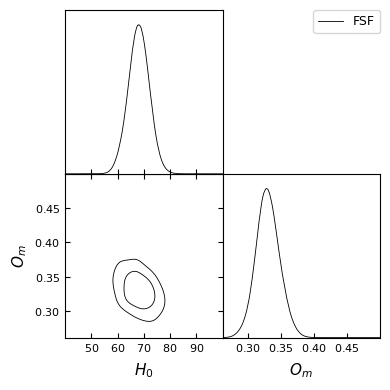

In [16]:
samples_FSF = loadMCSamples("chains/FSF")
logzFSF = "chains/FSF.logZ"

MCResult_cobaya(samples_FSF, logzFSF)

gFSF = plots.getSubplotPlotter()
gFSF.triangle_plot([samples_FSF], ["H0", "Om"], filled=False, legend_labels=["FSF"])
plt.show()

[root] *WARNING* auto bandwidth for M very small or failed (h=0.0006913104949627469,N_eff=834.084385253386). Using fallback (h=0.10013097656975857)
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2__lnlikehz
M = -0.0297 +19.5297 +19.5297 -19.5297 -19.5297
H0 = 67.2380 +4.1387 +8.3165 -4.1387 -8.3165
Om = 0.3310 +0.0165 +0.0377 -0.0165 -0.0377

Evidência Bayesiana:
logZ = -709.024 +/- 0.104


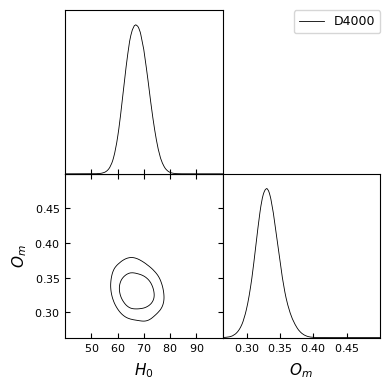

In [17]:
samples_D4000 = loadMCSamples("chains/D4000")
logzD4000 = "chains/D4000.logZ"

MCResult_cobaya(samples_D4000, logzD4000)

gD4000 = plots.getSubplotPlotter()
gD4000.triangle_plot([samples_D4000], ["H0", "Om"], filled=False, legend_labels=["D4000"])
plt.show()

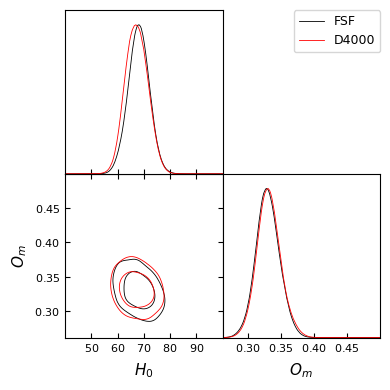

In [18]:
g = plots.getSubplotPlotter()
g.triangle_plot([samples_FSF, samples_D4000], ["H0", "Om"], filled=False, legend_labels=["FSF","D4000"])
plt.show()

M = 0.4321 +19.0679 +19.0679 -19.0679 -19.0679
H0 = 66.7113 +4.6731 +8.8865 -4.6731 -8.8865
Om = 0.3345 +0.0439 +0.1101 -0.0439 -0.1101
f = 0.7295 +0.0810 +0.2043 -0.0810 -0.2043

Evidência Bayesiana:
logZ = -103.166 +/- 0.140


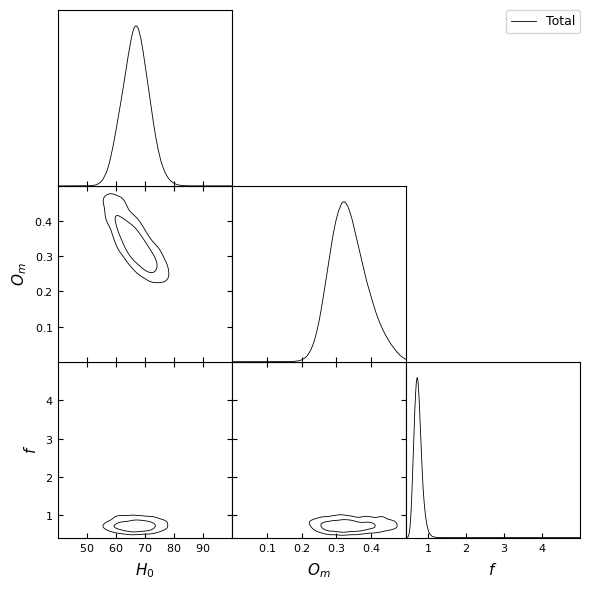

In [14]:
samples = loadMCSamples("chains/Total")
logz = "chains/Total.logZ"

MCResult_cobaya(samples, logz)

gTotal = plots.getSubplotPlotter()
gTotal.triangle_plot([samples], ["H0", "Om", "f"], filled=False, legend_labels=["Total"])
plt.show()

In [15]:
_, inv = CovMatTot(0.7295)
print(chi2Hz([0.4321, 66.7113, 0.3345, 0.7295, inv]))

27.321394802795112


In [ ]:
# Se a variável 'samples' já estiver na memória, pode saltar esta linha
samples = loadMCSamples("chains/Total")

# 1. Obter a matriz de correlação (array NumPy)
correlation_matrix = samples.getCorrelationMatrix()

# 2. Obter os nomes dos parâmetros (H0, Om, f, M)
# Usamos os nomes definidos no seu info (Célula 18)
param_names = ["H0", "Om", "f", "M"]
# (Ajuste esta lista se o 'samples' tiver os parâmetros em ordem diferente)
# Ou, de forma programática:
# param_names = [par.name for par in samples.getParamNames().names if par.name in ["M", "H0", "Om", "f"]]

# 3. Criar um DataFrame do Pandas para uma visualização clara
df_corr = pd.DataFrame(correlation_matrix, columns=param_names, index=param_names)

print("Matriz de Correlação (Coeficientes de Pearson r) - Análise Total (CC-only):")
print(df_corr)

# 4. Extrair os valores específicos que você viu como elipses inclinadas
print("\n--- Correlações (Degenerescências) ---")
print(f"Correlação H0 vs Om: {df_corr.loc['H0', 'Om']:.4f}")
print(f"Correlação f vs H0:  {df_corr.loc['f', 'H0']:.4f}")
print(f"Correlação f vs Om:  {df_corr.loc['f', 'Om']:.4f}")